In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import numpy as np
from pathlib import Path
import json
import time
from datetime import datetime
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_recall_fscore_support,
    accuracy_score
)

try:
    from mamba_ssm import Mamba
except ImportError:
    print("Warning: mamba_ssm not installed. Install with: pip install mamba-ssm")
    Mamba = None

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.4.0+cu121
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4060


In [31]:
POSE_EDGES = [
    (11, 13), (13, 15),     # left arm
    (12, 14), (14, 16),     # right arm
    (11, 12),               # shoulders
    (11, 23), (12, 24),     # torso
    (23, 24),               # hips
]

LEFT_HAND_BASE = 33

LEFT_HAND_EDGES = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9,10), (10,11), (11,12),
    (0,13), (13,14), (14,15), (15,16),
    (0,17), (17,18), (18,19), (19,20),
]

LEFT_HAND_EDGES = [
    (a + LEFT_HAND_BASE, b + LEFT_HAND_BASE)
    for a, b in LEFT_HAND_EDGES
]

RIGHT_HAND_BASE = 54

RIGHT_HAND_EDGES = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9,10), (10,11), (11,12),
    (0,13), (13,14), (14,15), (15,16),
    (0,17), (17,18), (18,19), (19,20),
]

RIGHT_HAND_EDGES = [
    (a + RIGHT_HAND_BASE, b + RIGHT_HAND_BASE)
    for a, b in RIGHT_HAND_EDGES
]

EDGES = POSE_EDGES + LEFT_HAND_EDGES + RIGHT_HAND_EDGES
NUM_JOINTS = 75

In [32]:
def build_adjacency(num_nodes, edges):
    A = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    for i, j in edges:
        A[i, j] = 1
        A[j, i] = 1
    return A

In [33]:
def add_self_loops(A):
    return A + np.eye(A.shape[0], dtype=A.dtype)

In [34]:
def add_self_loops(A):
    return A + np.eye(A.shape[0], dtype=A.dtype)

In [35]:
def normalize_adjacency(A):
    D = np.sum(A, axis=1)
    D_inv = np.diag(1.0 / (D + 1e-6))
    return D_inv @ A

In [36]:
def spatial_partition(A, center):
    num_nodes = A.shape[0]

    hop_dis = np.full((num_nodes, num_nodes), np.inf)
    for i in range(num_nodes):
        hop_dis[i, i] = 0

    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] > 0:
                hop_dis[i, j] = 1

    A_self = np.eye(num_nodes)
    A_in = np.zeros_like(A)
    A_out = np.zeros_like(A)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if hop_dis[j, center] == hop_dis[i, center] + 1:
                A_in[j, i] = A[j, i]
            elif hop_dis[j, center] == hop_dis[i, center] - 1:
                A_out[j, i] = A[j, i]

    return A_self, A_in, A_out


In [37]:
class Config:
    """Centralized configuration for training"""
    
    # Paths
    TRAIN_SEQ = "processed/seq/seq_train"
    TRAIN_MASK = "processed/mask/mask_train"
    VAL_SEQ = "processed/seq/seq_val"
    VAL_MASK = "processed/mask/mask_val"
    TEST_SEQ = "processed/seq/seq_test"
    TEST_MASK = "processed/mask/mask_test"
    
    # Model parameters
    IN_CHANNELS = 3
    NUM_JOINTS = 75
    
    # Training parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    
    # Scheduler
    STEP_SIZE = 20
    GAMMA = 0.1
    
    # Optimizer
    GRAD_CLIP = 1.0
    
    # Saving
    CHECKPOINT_DIR = "checkpoints_mamba"
    RESULTS_DIR = "results_mamba"
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 0  # should be 4 but Kaggle dont support multiprocessing i guess

# Create directories
Path(Config.CHECKPOINT_DIR).mkdir(exist_ok=True)
Path(Config.RESULTS_DIR).mkdir(exist_ok=True)

print(f"Training Device: {Config.DEVICE}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Learning Rate: {Config.LEARNING_RATE}")

Training Device: cuda
Batch Size: 16
Learning Rate: 0.001


In [38]:
def downsample_mask(mask, stride):
    """
    Downsample temporal mask by taking max over stride windows.
    
    Args:
        mask: (N, T) tensor of 0s and 1s
        stride: downsampling factor
    
    Returns:
        mask_down: (N, T_down) downsampled mask
    """
    if stride == 1:
        return mask
    
    mask = mask.unsqueeze(1)  # (N, 1, T)
    mask = F.max_pool1d(mask, kernel_size=stride, stride=stride, ceil_mode=False)
    return mask.squeeze(1)  # (N, T_down)


def format_time(seconds):
    """Convert seconds to readable time format"""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

In [39]:
"""
Mamba-GCN: Spatial-Temporal Graph Convolutional Network with Mamba
Replaces TCN with Mamba for improved temporal modeling
"""

class MambaGCNBlock(nn.Module):
    """
    Spatial-Temporal Graph Convolutional Block with Mamba
    
    Architecture:
        Input -> GCN (Spatial) -> Mamba (Temporal) -> Residual -> Output
    """
    
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True, dropout=0.5):
        super().__init__()
        
        self.register_buffer("A", torch.tensor(A, dtype=torch.float32))
        self.K = A.shape[0]  # Number of spatial partitions
        self.stride = stride
        self.out_channels = out_channels
        
        # ============================================================
        # SPATIAL: Graph Convolution (unchanged from ST-GCN)
        # ============================================================
        self.gcn = nn.Conv2d(
            in_channels,
            out_channels * self.K,
            kernel_size=1
        )
        
        # ============================================================
        # TEMPORAL: Mamba Block (replaces TCN)
        # ============================================================
        # Mamba expects input of shape (batch, length, dim)
        # We'll apply it per-joint: (N*V, T, C)
        
        self.pre_mamba_norm = nn.BatchNorm1d(out_channels)
        
        if Mamba is not None:
            self.mamba = Mamba(
                d_model=out_channels,  # Model dimension (channels)
                d_state=16,            # SSM state expansion factor
                d_conv=4,              # Local convolution width
                expand=2,              # Block expansion factor
            )
        else:
            # Fallback to simple linear if Mamba not available
            self.mamba = nn.Linear(out_channels, out_channels)
        
        self.post_mamba_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(p=dropout)
        
        # Temporal downsampling (if stride > 1)
        if stride > 1:
            self.temporal_pool = nn.AvgPool1d(kernel_size=stride, stride=stride)
        else:
            self.temporal_pool = None
        
        # ============================================================
        # RESIDUAL CONNECTION
        # ============================================================
        if not residual:
            self.residual = lambda x: 0
        elif in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)
                ),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, mask):
        """
        Args:
            x: (N, C, T, V) - features
            mask: (N, T) - temporal mask
        
        Returns:
            x: (N, C, T', V) - output features
            mask: (N, T') - downsampled mask
        """
        N, C_in, T, V = x.shape
        
        # ============================================================
        # SPATIAL: Graph Convolution
        # ============================================================
        x_gcn = self.gcn(x)  # (N, C_out*K, T, V)
        x_gcn = x_gcn.view(N, self.K, self.out_channels, T, V)  # (N, K, C_out, T, V)
        x_gcn = torch.einsum('nkctv,kvw->nctw', x_gcn, self.A)  # (N, C_out, T, V)
        
        # ============================================================
        # TEMPORAL: Mamba Block
        # ============================================================
        # Reshape for per-joint temporal processing
        # (N, C, T, V) -> (N*V, C, T) -> (N*V, T, C)
        x_temp = x_gcn.permute(0, 3, 1, 2).contiguous()  # (N, V, C, T)
        x_temp = x_temp.view(N * V, self.out_channels, T)  # (N*V, C, T)
        
        # Apply batch norm
        x_temp = self.pre_mamba_norm(x_temp)  # (N*V, C, T)
        
        # Transpose for Mamba: (N*V, T, C)
        x_temp = x_temp.transpose(1, 2)  # (N*V, T, C)
        
        # Apply Mamba
        x_mamba = self.mamba(x_temp)  # (N*V, T, C)
        
        # Transpose back: (N*V, C, T)
        x_mamba = x_mamba.transpose(1, 2)  # (N*V, C, T)
        
        # Apply post-norm and dropout
        x_mamba = self.post_mamba_norm(x_mamba)  # (N*V, C, T)
        x_mamba = self.dropout(x_mamba)
        
        # Temporal downsampling if needed
        if self.temporal_pool is not None:
            x_mamba = self.temporal_pool(x_mamba)  # (N*V, C, T')
            T_new = x_mamba.shape[2]
        else:
            T_new = T
        
        # Reshape back: (N*V, C, T') -> (N, V, C, T') -> (N, C, T', V)
        x_mamba = x_mamba.view(N, V, self.out_channels, T_new)
        x_mamba = x_mamba.permute(0, 2, 3, 1).contiguous()  # (N, C, T', V)
        
        # ============================================================
        # RESIDUAL CONNECTION
        # ============================================================
        res = self.residual(x)  # (N, C, T', V)
        x_out = x_mamba + res
        
        # ============================================================
        # MASK HANDLING
        # ============================================================
        # Downsample mask if stride > 1
        if self.stride > 1:
            mask = mask.unsqueeze(1)  # (N, 1, T)
            mask = F.max_pool1d(mask, kernel_size=self.stride, stride=self.stride)
            mask = mask.squeeze(1)  # (N, T')
        
        # Apply mask
        x_out = x_out * mask[:, None, :, None]
        
        return self.relu(x_out), mask


class MambaGCN(nn.Module):
    """
    Mamba-GCN: Spatial-Temporal Graph Convolutional Network with Mamba
    for Skeleton-based Action Recognition
    """
    
    def __init__(self, num_classes, A, in_channels=3, dropout=0.5):
        super().__init__()
        
        # Input Batch Normalization
        self.data_bn = nn.BatchNorm1d(in_channels * A.shape[1])
        
        # Mamba-GCN Blocks
        self.layer1 = MambaGCNBlock(in_channels, 64, A, stride=1, residual=False, dropout=dropout)
        self.layer2 = MambaGCNBlock(64, 64, A, stride=1, dropout=dropout)
        self.layer3 = MambaGCNBlock(64, 64, A, stride=1, dropout=dropout)
        self.layer4 = MambaGCNBlock(64, 128, A, stride=2, dropout=dropout)
        self.layer5 = MambaGCNBlock(128, 256, A, stride=2, dropout=dropout)
        
        # Classifier
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x, mask):
        """
        Args:
            x: (N, C, T, V) - input skeleton sequences
            mask: (N, T) - temporal mask
        
        Returns:
            logits: (N, num_classes) - classification logits
        """
        N, C, T, V = x.shape
        
        # Input normalization
        x = x.permute(0, 3, 1, 2).contiguous()  # (N, V, C, T)
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1)  # (N, C, T, V)
        
        # Mamba-GCN layers
        x, mask = self.layer1(x, mask)
        x, mask = self.layer2(x, mask)
        x, mask = self.layer3(x, mask)
        x, mask = self.layer4(x, mask)
        x, mask = self.layer5(x, mask)
        
        # Masked Global Average Pooling
        x = x * mask[:, None, :, None]  # Apply mask
        x_sum = x.sum(dim=[2, 3])  # (N, C)
        valid_count = mask.sum(dim=1, keepdim=True) * V  # (N, 1)
        x = x_sum / (valid_count + 1e-6)  # Avoid division by zero
        
        # Classification
        logits = self.fc(x)
        return logits



In [40]:
class SkeletonDataset(Dataset):
    def __init__(self, seq_dir, mask_dir, class_to_idx):
        self.samples = []
        self.class_to_idx = class_to_idx
        
        seq_dir = Path(seq_dir)
        mask_dir = Path(mask_dir)
        
        for class_name in sorted(seq_dir.iterdir()):
            if not class_name.is_dir():
                continue
            
            label = self.class_to_idx[class_name.name]
            
            for file in class_name.glob("*.npy"):
                mask_name = file.name.replace('_seq.npy', '_mask.npy')
                mask_file = mask_dir / class_name.name / mask_name
                
                if mask_file.exists():
                    self.samples.append((file, mask_file, label))
        
        print(f"Loaded {len(self.samples)} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        seq_path, mask_path, label = self.samples[idx]
        
        seq = np.load(seq_path)  # (T, V, C)
        mask = np.load(mask_path)  # (T,)
        
        seq = torch.tensor(seq, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        seq = seq.permute(2, 0, 1)  # (C, T, V)
        
        return seq, mask, label

# Build class mapping
classes = sorted([p.name for p in Path(Config.TRAIN_SEQ).iterdir() if p.is_dir()])
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

print(f"Number of classes: {len(classes)}")

# Create datasets
train_dataset = SkeletonDataset(Config.TRAIN_SEQ, Config.TRAIN_MASK, class_to_idx)
val_dataset = SkeletonDataset(Config.VAL_SEQ, Config.VAL_MASK, class_to_idx)
test_dataset = SkeletonDataset(Config.TEST_SEQ, Config.TEST_MASK, class_to_idx)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Number of classes: 121
Loaded 4235 samples
Loaded 847 samples
Loaded 968 samples
Train batches: 265
Val batches: 53
Test batches: 61


In [41]:
class MetricsTracker:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.predictions = []
        self.targets = []
        self.losses = []
    
    def update(self, outputs, targets, loss):
        preds = torch.argmax(outputs, dim=1)
        self.predictions.extend(preds.cpu().numpy())
        self.targets.extend(targets.cpu().numpy())
        self.losses.append(loss)
    
    def compute(self):
        avg_loss = np.mean(self.losses)
        accuracy = accuracy_score(self.targets, self.predictions)
        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'predictions': np.array(self.predictions),
            'targets': np.array(self.targets)
        }

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    tracker = MetricsTracker()
    
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for seq, mask, labels in pbar:
        seq = seq.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(seq, mask)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=Config.GRAD_CLIP)
        optimizer.step()
        
        tracker.update(outputs.detach(), labels, loss.item())
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    return tracker.compute()
    

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    tracker = MetricsTracker()
    
    pbar = tqdm(loader, desc="Validation", leave=False)
    for seq, mask, labels in pbar:
        seq = seq.to(device)
        mask = mask.to(device)
        labels = labels.to(device)
        
        outputs = model(seq, mask)
        loss = criterion(outputs, labels)
        
        tracker.update(outputs, labels, loss.item())
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    return tracker.compute()

In [42]:
CENTER_JOINT = 11  # left shoulder 
A = build_adjacency(NUM_JOINTS, EDGES)
A = add_self_loops(A)
A = normalize_adjacency(A)

A_self, A_in, A_out = spatial_partition(A, CENTER_JOINT)

A_stgcn = np.stack([A_self, A_in, A_out], axis=0)

# Initialize model
model = MambaGCN(
    num_classes=len(classes),
    A=A_stgcn,
    in_channels=Config.IN_CHANNELS,
    dropout=0.5
).to(Config.DEVICE)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=Config.STEP_SIZE, gamma=Config.GAMMA)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 877,883
Trainable parameters: 877,883


In [43]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc = 0.0
best_epoch = 0
best_model_path = Path(Config.CHECKPOINT_DIR) / "best_mamba_gcn.pth"

print(f"\n{'='*60}")
print(f"Starting Mamba-GCN Training - {Config.NUM_EPOCHS} Epochs")
print(f"{'='*60}\n")

start_time = time.time()

for epoch in range(Config.NUM_EPOCHS):
    epoch_start = time.time()
    
    train_results = train_one_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)
    val_results = validate(model, val_loader, criterion, Config.DEVICE)
    
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    history['train_loss'].append(train_results['loss'])
    history['train_acc'].append(train_results['accuracy'])
    history['val_loss'].append(val_results['loss'])
    history['val_acc'].append(val_results['accuracy'])
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    elapsed_time = time.time() - start_time
    
    print(f"Epoch [{epoch+1:3d}/{Config.NUM_EPOCHS}] "
          f"| Train Loss: {train_results['loss']:.4f} "
          f"| Train Acc: {train_results['accuracy']:.4f} "
          f"| Val Loss: {val_results['loss']:.4f} "
          f"| Val Acc: {val_results['accuracy']:.4f} "
          f"| LR: {current_lr:.6f} "
          f"| Time: {format_time(epoch_time)}")
    
    if val_results['accuracy'] > best_val_acc:
        best_val_acc = val_results['accuracy']
        best_epoch = epoch + 1
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history,
            'class_to_idx': class_to_idx
        }
        torch.save(checkpoint, best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {best_val_acc:.4f})")

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Val Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"{'='*60}\n")

# Save history
with open(Path(Config.RESULTS_DIR) / "training_history_mamba.json", 'w') as f:
    json.dump(history, f, indent=2)


Starting Mamba-GCN Training - 50 Epochs



Epoch [  1/50] | Train Loss: 4.6507 | Train Acc: 0.0130 | Val Loss: 4.3436 | Val Acc: 0.0236 | LR: 0.001000 | Time: 00:03:14
  ✓ New best model saved! (Val Acc: 0.0236)


Epoch [  2/50] | Train Loss: 4.1237 | Train Acc: 0.0418 | Val Loss: 555945591095609.0000 | Val Acc: 0.0744 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.0744)


Epoch [  3/50] | Train Loss: 3.5402 | Train Acc: 0.0930 | Val Loss: nan | Val Acc: 0.1582 | LR: 0.001000 | Time: 00:02:28
  ✓ New best model saved! (Val Acc: 0.1582)


Epoch [  4/50] | Train Loss: 3.1610 | Train Acc: 0.1426 | Val Loss: nan | Val Acc: 0.2113 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.2113)


Epoch [  5/50] | Train Loss: 2.8881 | Train Acc: 0.2064 | Val Loss: nan | Val Acc: 0.2373 | LR: 0.001000 | Time: 00:02:30
  ✓ New best model saved! (Val Acc: 0.2373)


Epoch [  6/50] | Train Loss: 2.6057 | Train Acc: 0.2699 | Val Loss: nan | Val Acc: 0.2975 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.2975)


Epoch [  7/50] | Train Loss: 2.4029 | Train Acc: 0.3162 | Val Loss: nan | Val Acc: 0.3270 | LR: 0.001000 | Time: 00:02:30
  ✓ New best model saved! (Val Acc: 0.3270)


Epoch [  8/50] | Train Loss: 2.2220 | Train Acc: 0.3627 | Val Loss: nan | Val Acc: 0.4203 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.4203)


Epoch [  9/50] | Train Loss: 2.0371 | Train Acc: 0.4017 | Val Loss: 1.9007 | Val Acc: 0.4498 | LR: 0.001000 | Time: 00:02:30
  ✓ New best model saved! (Val Acc: 0.4498)


Epoch [ 10/50] | Train Loss: 1.8714 | Train Acc: 0.4560 | Val Loss: 1.7258 | Val Acc: 0.5089 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.5089)


Epoch [ 11/50] | Train Loss: 1.7199 | Train Acc: 0.4893 | Val Loss: nan | Val Acc: 0.5183 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.5183)


Epoch [ 12/50] | Train Loss: 1.5652 | Train Acc: 0.5405 | Val Loss: nan | Val Acc: 0.5478 | LR: 0.001000 | Time: 00:02:28
  ✓ New best model saved! (Val Acc: 0.5478)


Epoch [ 13/50] | Train Loss: 1.4473 | Train Acc: 0.5710 | Val Loss: 3505582002227840976683008.0000 | Val Acc: 0.6446 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.6446)


Epoch [ 14/50] | Train Loss: 1.3351 | Train Acc: 0.5967 | Val Loss: 1.3266 | Val Acc: 0.6364 | LR: 0.001000 | Time: 00:02:28


Epoch [ 15/50] | Train Loss: 1.2294 | Train Acc: 0.6420 | Val Loss: nan | Val Acc: 0.6706 | LR: 0.001000 | Time: 00:03:12
  ✓ New best model saved! (Val Acc: 0.6706)


Epoch [ 16/50] | Train Loss: 1.1557 | Train Acc: 0.6574 | Val Loss: nan | Val Acc: 0.6741 | LR: 0.001000 | Time: 00:02:37
  ✓ New best model saved! (Val Acc: 0.6741)


Epoch [ 17/50] | Train Loss: 1.0682 | Train Acc: 0.6836 | Val Loss: 78804359210.1530 | Val Acc: 0.6895 | LR: 0.001000 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.6895)


Epoch [ 18/50] | Train Loss: 0.9977 | Train Acc: 0.7060 | Val Loss: 43495605152.3683 | Val Acc: 0.7367 | LR: 0.001000 | Time: 00:02:28
  ✓ New best model saved! (Val Acc: 0.7367)


Epoch [ 19/50] | Train Loss: 0.9450 | Train Acc: 0.7174 | Val Loss: nan | Val Acc: 0.7355 | LR: 0.001000 | Time: 00:02:29


Epoch [ 20/50] | Train Loss: 0.8980 | Train Acc: 0.7339 | Val Loss: 0.9088 | Val Acc: 0.7344 | LR: 0.001000 | Time: 00:02:28


Epoch [ 21/50] | Train Loss: 0.7369 | Train Acc: 0.7979 | Val Loss: 0.7982 | Val Acc: 0.8123 | LR: 0.000100 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.8123)


Epoch [ 22/50] | Train Loss: 0.6674 | Train Acc: 0.8359 | Val Loss: 5249208809144.7744 | Val Acc: 0.8099 | LR: 0.000100 | Time: 00:02:29


Epoch [ 23/50] | Train Loss: 0.6716 | Train Acc: 0.8298 | Val Loss: 0.7048 | Val Acc: 0.8146 | LR: 0.000100 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.8146)


Epoch [ 24/50] | Train Loss: 0.6487 | Train Acc: 0.8298 | Val Loss: 0.7119 | Val Acc: 0.8111 | LR: 0.000100 | Time: 00:02:28


Epoch [ 25/50] | Train Loss: 0.6436 | Train Acc: 0.8397 | Val Loss: 81354403.2642 | Val Acc: 0.8170 | LR: 0.000100 | Time: 00:02:28
  ✓ New best model saved! (Val Acc: 0.8170)


Epoch [ 26/50] | Train Loss: 0.6096 | Train Acc: 0.8460 | Val Loss: 0.6641 | Val Acc: 0.8205 | LR: 0.000100 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.8205)


Epoch [ 27/50] | Train Loss: 0.6012 | Train Acc: 0.8517 | Val Loss: 142086900305336624.0000 | Val Acc: 0.8194 | LR: 0.000100 | Time: 00:02:29


Epoch [ 28/50] | Train Loss: 0.6150 | Train Acc: 0.8463 | Val Loss: 0.6640 | Val Acc: 0.8288 | LR: 0.000100 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.8288)


Epoch [ 29/50] | Train Loss: 0.5936 | Train Acc: 0.8541 | Val Loss: 0.6572 | Val Acc: 0.8241 | LR: 0.000100 | Time: 00:02:28


Epoch [ 30/50] | Train Loss: 0.5871 | Train Acc: 0.8494 | Val Loss: 4526151.2890 | Val Acc: 0.8253 | LR: 0.000100 | Time: 00:02:29


Epoch [ 31/50] | Train Loss: 0.5821 | Train Acc: 0.8536 | Val Loss: 0.6536 | Val Acc: 0.8300 | LR: 0.000100 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.8300)


Epoch [ 32/50] | Train Loss: 0.5806 | Train Acc: 0.8545 | Val Loss: 334953.0811 | Val Acc: 0.8276 | LR: 0.000100 | Time: 00:02:29


Epoch [ 33/50] | Train Loss: 0.5706 | Train Acc: 0.8638 | Val Loss: 0.6389 | Val Acc: 0.8406 | LR: 0.000100 | Time: 00:02:29
  ✓ New best model saved! (Val Acc: 0.8406)


Epoch [ 34/50] | Train Loss: 0.5697 | Train Acc: 0.8586 | Val Loss: 0.6326 | Val Acc: 0.8394 | LR: 0.000100 | Time: 00:02:29


Epoch [ 35/50] | Train Loss: 0.5653 | Train Acc: 0.8586 | Val Loss: 1327840.7833 | Val Acc: 0.8394 | LR: 0.000100 | Time: 00:02:32


Epoch [ 36/50] | Train Loss: 0.5470 | Train Acc: 0.8633 | Val Loss: 0.6343 | Val Acc: 0.8418 | LR: 0.000100 | Time: 00:02:35
  ✓ New best model saved! (Val Acc: 0.8418)


Epoch [ 37/50] | Train Loss: 0.5454 | Train Acc: 0.8737 | Val Loss: 0.5987 | Val Acc: 0.8418 | LR: 0.000100 | Time: 00:02:35


Epoch [ 38/50] | Train Loss: 0.5370 | Train Acc: 0.8718 | Val Loss: nan | Val Acc: 0.8323 | LR: 0.000100 | Time: 00:02:34


Epoch [ 39/50] | Train Loss: 0.5338 | Train Acc: 0.8678 | Val Loss: 906610187717960448.0000 | Val Acc: 0.8430 | LR: 0.000100 | Time: 00:02:35
  ✓ New best model saved! (Val Acc: 0.8430)


Epoch [ 40/50] | Train Loss: 0.5203 | Train Acc: 0.8749 | Val Loss: 0.5806 | Val Acc: 0.8489 | LR: 0.000100 | Time: 00:02:36
  ✓ New best model saved! (Val Acc: 0.8489)


Epoch [ 41/50] | Train Loss: 0.5170 | Train Acc: 0.8737 | Val Loss: 606289.1857 | Val Acc: 0.8512 | LR: 0.000010 | Time: 00:02:35
  ✓ New best model saved! (Val Acc: 0.8512)


Epoch [ 42/50] | Train Loss: 0.5045 | Train Acc: 0.8852 | Val Loss: 4487173617.1572 | Val Acc: 0.8383 | LR: 0.000010 | Time: 00:02:35


Epoch [ 43/50] | Train Loss: 0.5081 | Train Acc: 0.8836 | Val Loss: 2410560212.8130 | Val Acc: 0.8489 | LR: 0.000010 | Time: 00:02:35


Epoch [ 44/50] | Train Loss: 0.5142 | Train Acc: 0.8800 | Val Loss: 3967242337.1786 | Val Acc: 0.8512 | LR: 0.000010 | Time: 00:02:35


Epoch [ 45/50] | Train Loss: 0.4998 | Train Acc: 0.8831 | Val Loss: nan | Val Acc: 0.8524 | LR: 0.000010 | Time: 00:02:34
  ✓ New best model saved! (Val Acc: 0.8524)


Epoch [ 46/50] | Train Loss: 0.4974 | Train Acc: 0.8855 | Val Loss: 0.5784 | Val Acc: 0.8477 | LR: 0.000010 | Time: 00:02:34


Epoch [ 47/50] | Train Loss: 0.4926 | Train Acc: 0.8883 | Val Loss: 22176219226118184.0000 | Val Acc: 0.8465 | LR: 0.000010 | Time: 00:02:35


Epoch [ 48/50] | Train Loss: 0.4962 | Train Acc: 0.8855 | Val Loss: 0.5808 | Val Acc: 0.8524 | LR: 0.000010 | Time: 00:02:35


Epoch [ 49/50] | Train Loss: 0.4901 | Train Acc: 0.8895 | Val Loss: 0.5756 | Val Acc: 0.8548 | LR: 0.000010 | Time: 00:02:35
  ✓ New best model saved! (Val Acc: 0.8548)


Epoch [ 50/50] | Train Loss: 0.5007 | Train Acc: 0.8841 | Val Loss: 0.5938 | Val Acc: 0.8465 | LR: 0.000010 | Time: 00:02:35

Training Complete!
Total Time: 02:07:40
Best Val Accuracy: 0.8548 (Epoch 49)



In [46]:
def plot_training_history(history, save_path=None):
    """Plot training and validation metrics"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
    axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=4)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2, markersize=4)
    axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Accuracy', linewidth=2, markersize=4)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history saved to {save_path}")
    
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None, normalize=False):
    """
    Plot confusion matrix with optional normalization
    
    Args:
        normalize: If True, normalize by true class (shows recall)
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
    else:
        title = 'Confusion Matrix'
        fmt = 'd'
    
    plt.figure(figsize=(max(12, len(class_names) * 0.3), max(10, len(class_names) * 0.3)))
    
    sns.heatmap(
        cm,
        annot=False,  # Too many classes for annotations
        fmt=fmt,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Proportion' if normalize else 'Count'}
    )
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()
    
    return cm


def print_metrics_summary(metrics, split_name="Validation"):
    """Print formatted metrics summary"""
    
    print(f"\n{'='*60}")
    print(f"{split_name} Metrics Summary")
    print(f"{'='*60}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"\nMacro Averages:")
    print(f"  Precision: {metrics['macro_avg']['precision']:.4f}")
    print(f"  Recall:    {metrics['macro_avg']['recall']:.4f}")
    print(f"  F1-Score:  {metrics['macro_avg']['f1_score']:.4f}")
    print(f"\nWeighted Averages:")
    print(f"  Precision: {metrics['weighted_avg']['precision']:.4f}")
    print(f"  Recall:    {metrics['weighted_avg']['recall']:.4f}")
    print(f"  F1-Score:  {metrics['weighted_avg']['f1_score']:.4f}")
    print(f"{'='*60}\n")

Training history saved to results_mamba/training_curves.png


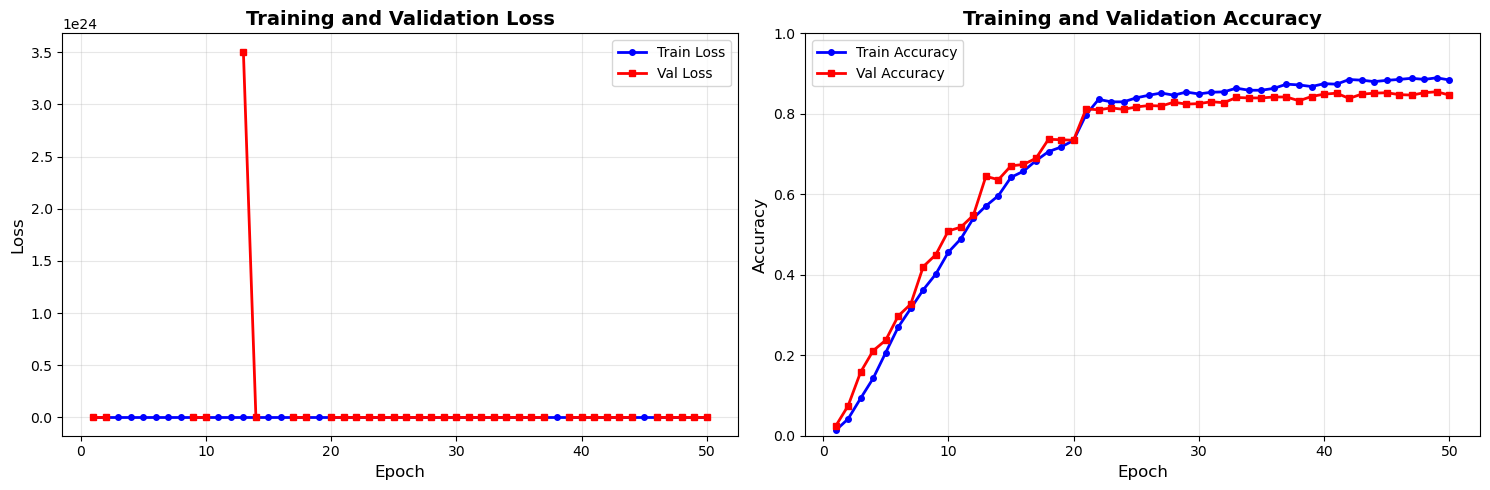

In [ ]:
# Plot training curves
with open("results_mamba/training_history_mamba.json", "r") as f:
    history = json.load(f
    plot_path = r"results_mamba/training_curves.png"
    plot_training_history(history, save_path=plot_path)
    